# Laplacian of Gaussian with Difference of Gaussian
The Laplacian of Gaussian (LoG) can be used to detect blobs in images. Classic methods using the LoG blur the image with differing amounts to reduce the effect of noise, especially since the LoG requires second-order derivatives.

David Lowe found that the LoG can be approximated with a difference of Gaussians with increasing sigmas. Combining this with an image pyramid, he created the scale-invariant feature transform (SIFT).

This code shows a single octave for the SIFT algorithm.

![octave](res/octave.png)

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


image_path = '9.jpg'

resize = 0.25

# Read in image as RGB just to show
image_rgb = Image.open(image_path)

# Resize RGB image
w_rgb = int(image_rgb.width * resize)
h_rgb = int(image_rgb.height * resize)
image_rgb = image_rgb.resize((w_rgb, h_rgb))
display(image_rgb)

# Read in image as grayscale for operations
image = Image.open(image_path).convert('L')

# Resize gray image
w = int(image.width * resize)
h = int(image.height * resize)
image = image.resize((w, h))

# Store as array
image = np.array(image)

print(f'Read in {image_path}. Shape: {image.shape}')
width = image.shape[1]
height = image.shape[0]
Image.fromarray(image)

### Top and bottom n percent removal
For visualization purposes, contrast can be improved by removing the top and bottom $n$ percent of data.

In [ ]:
def RemoveTopBottomNPercent(input: np.ndarray, 
                            n: float, 
                            print_output: bool = False) -> np.ndarray:
    sorted = np.sort(np.ndarray.flatten(input))
    outliers_idx = int(n / 100 * sorted.size)

    bottom = sorted[outliers_idx]
    # If the index exceeds the size, just use the last element
    # Doesn't occur unless 0 is input for n
    top = sorted[sorted.size - outliers_idx if outliers_idx != 0 else -1]

    if print_output:
        print(f'Removing top and bottom {n:.2f}% of data.')
        print(f'Bottom: {bottom:.2f}\nTop: {top:.2f}')

    input[input < bottom] = 0
    input[input > top] = 0

    return input

## Scale space
In SIFT, an octave is defined as an image at a certain resolution, but with increasing Gaussian blurs applied. It's recommended to have at least 5 different scales within an octave.

In [ ]:
from scipy.ndimage import gaussian_filter
from matplotlib import pyplot as plt

def CreateScaleSpace(image: np.ndarray, scales: int = 5, start_sigma: float = 1, 
                     multiplier: float = np.sqrt(2), extra: int = 0,
                     visualize: bool = False) -> list:
    scale_space = []
    sigmas = [start_sigma]

    for i in np.arange(scales + extra):
        scale_space.append(gaussian_filter(image.astype(np.double), sigmas[i]))
        sigmas.append(multiplier * sigmas[i])

        # Show scale space within octave
        if visualize:
            plt.figure()
            plt.title(f'Scale {sigmas[i]:.2f}')
            plt.imshow(scale_space[i], cmap='gray')

    return scale_space

## Difference of Gaussians

In [ ]:
def PerformDoG(scale_space: list, visualize: bool = False, 
               remove_n_perc: float = 5) -> list:
    DoGs = []

    for i in np.arange(len(scale_space) - 1):
        DoGs.append(scale_space[i] - scale_space[i + 1])

        if visualize:
            plt.figure(figsize=(10,10))
            plt.title(f'DoG')
            plt.imshow(RemoveTopBottomNPercent(DoGs[i], remove_n_perc))
            plt.colorbar()
    
    return DoGs

## Optima in DoG
Find the optima across three scales. If a pixel is the maximum or minimum out of its 26 neighbors, it is marked as a keypoint. The smallest and largest scales will not be used for keypoints. Why is that?

![Difference of Gaussian](res/dog.png)

In [ ]:
def GetResponses(DoGs: list) -> np.ndarray:
    scales = len(DoGs)
    DoGs = np.dstack(DoGs)

    rows, cols = DoGs.shape[0:2]
    responses = np.zeros((rows, cols))

    for i in np.arange(1, scales - 1):
        for row in np.arange(1, rows - 1):
            for col in np.arange(1, cols - 1):
                candidate = DoGs[row, col, i]

                neighborhood = DoGs[row-1:row+2, col-1:col+2, i-1:i+2]

                maxima = (candidate > neighborhood).sum()
                minima = (candidate < neighborhood).sum()

                if maxima == 26 or minima == 26:
                    responses[row, col] = candidate

    print(f'{np.count_nonzero(responses)} keypoints detected.')

    return responses

In [ ]:
# Non-maximal suppression
def NMS(responses: np.ndarray, 
        window_size: np.ndarray = np.array((20,20))) -> np.ndarray:
    rows, cols = responses.shape

    wind_rows = window_size[0]
    wind_cols = window_size[1]

    # Half rows/cols
    h_rows = int(wind_rows / 2)
    h_cols = int(wind_cols / 2)

    # Area used for maxima/minima sum check
    area = wind_rows * wind_cols

    filtered_responses = np.zeros(responses.shape)

    for row in np.arange(0 + h_rows, rows - h_rows):
        for col in np.arange(0 + h_cols, cols - h_cols):
            candidate = responses[row, col]

            # Grab neighborhood of points from responses
            neighborhood = np.array(responses[row - h_rows:row + h_rows,
                                              col - h_cols:col + h_cols])
            
            maxima = (candidate > neighborhood).sum()
            minima = (candidate < neighborhood).sum()

            if maxima == area - 1 or minima == area - 1:
                filtered_responses[row, col] = candidate

    print(f'{np.count_nonzero(responses)} original keypoints.')
    print(f'{np.count_nonzero(filtered_responses)} remaining keypoints after '
          'non-maximal suppression.')
    
    return filtered_responses

In [ ]:
def GetKeypointsFromResponses(responses: np.ndarray) -> np.ndarray:
    r_nonzero = responses.nonzero()
    filtered_keypoints = np.vstack((r_nonzero[0], r_nonzero[1]))

    return filtered_keypoints

## Plot Keypoints

In [ ]:
import cv2

def PlotKeypoints(image_path: str, w_resize: int, h_resize: int,
                  keypoints: np.ndarray):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (w_resize, h_resize))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for i in np.arange(keypoints.shape[1]):
        image = cv2.circle(image, (keypoints[1, i], keypoints[0, i]),
                           radius=3, color=(255,0,0), thickness=-1)
        
    plt.figure(figsize=(15,15))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)

### Get SIFT descriptors at keypoints

In [68]:
def GetSIFTDescriptors(keypoints: np.ndarray) -> np.ndarray:
    # Create list of OpenCV Keypoints
    kp = []
    keypoints = keypoints.astype(np.float64)
    for i in np.arange(keypoints.shape[1]):
        kp.append(cv2.KeyPoint(keypoints[0, i], keypoints[1, i], 1))

    # Describe SIFT points
    sift = cv2.SIFT_create()
    descriptors = sift.compute(image, kp)
    
    return descriptors

3997 keypoints detected.
3997 original keypoints.
2034 remaining keypoints after non-maximal suppression.


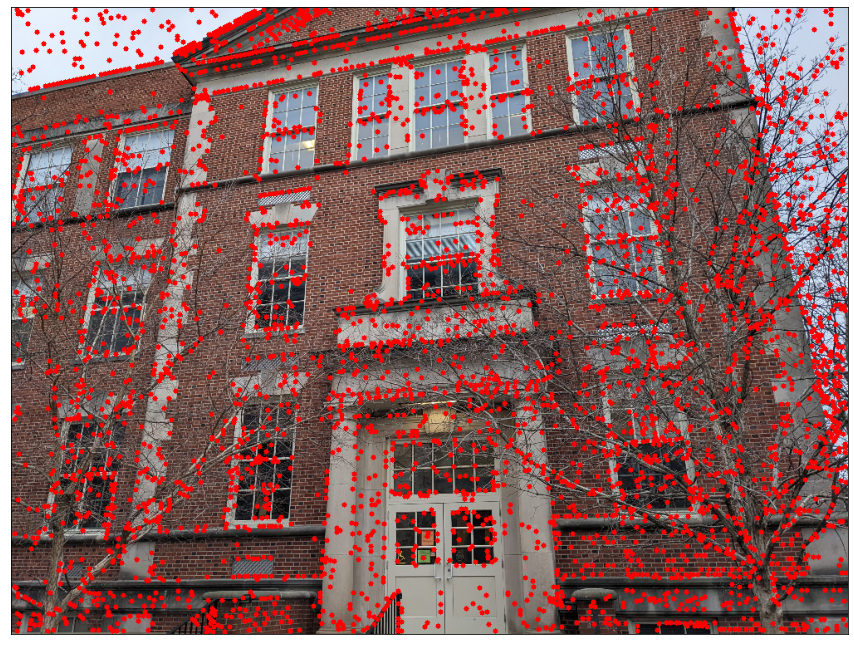

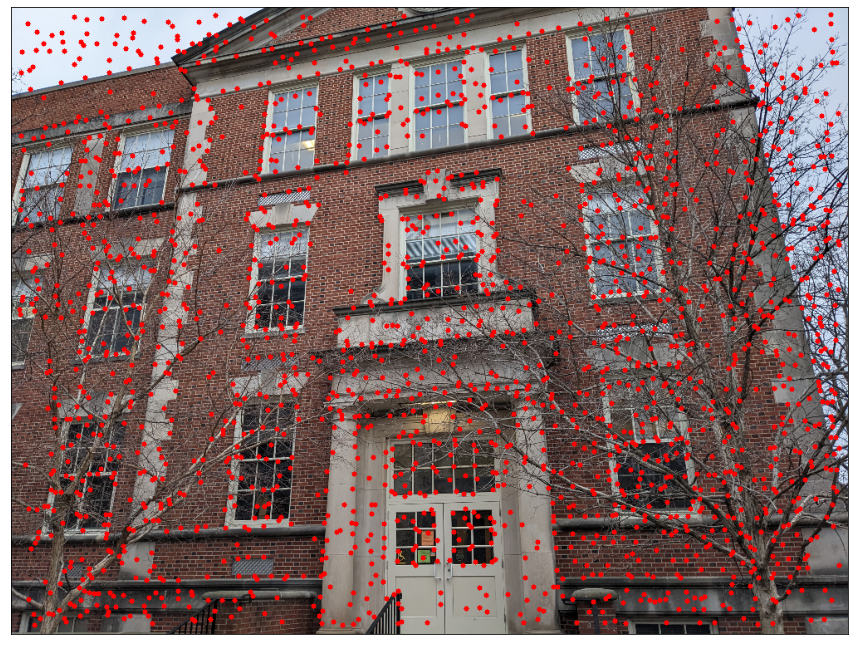

In [69]:
scale_space = CreateScaleSpace(image)
DoGs = PerformDoG(scale_space)
responses = GetResponses(DoGs)

# Non-maximal suppression
filt_res = NMS(responses)

# Keypoints for both original responses and NMS responses
orig_kp = GetKeypointsFromResponses(responses)
filt_kp = GetKeypointsFromResponses(filt_res)

# Plot keypoints on both original and NMS
PlotKeypoints(image_path, w, h, orig_kp)
PlotKeypoints(image_path, w, h, filt_kp)

# Get descriptors for NMS keypoints
desc = GetSIFTDescriptors(filt_kp)